In [392]:
#simple direct problem solving 
import matplotlib.pyplot as plt

from clspde.solution import Solution
from clspde.basis import Basis
import itertools
import numpy as np


power = 5
params = {
        'n_dims': 2,
        'dim_sizes': np.array([2, 2]),
        'area_lims': np.array([[0,0.1], [0,1]]),
        'power': power,
        'basis': Basis(power),
        'n_funcs': 1,
    }


alpha = 0#1e-3

def prepare_model(border_weight, colloc_weight, connect_weights):
    initial_weight = 1e2
    eps = 0.5

    sol = Solution(**params)

    w = 1
    k1 = connect_weights[0]
    k2 = connect_weights[1]
    # border_weight = 1
    # no_need_weight = 0

    itercoef=0.

    colloc_left_operators = [lambda u_loc, u_bas, x, x_loc:  (-alpha*u_bas([0,4],0)
                                                              +u_bas([1,0],0)
                                                                            -eps*u_bas([0,2],0)
                                                                                                -(eps*u_bas([0,1],0)/(x[1]+1)
                                                                                                 -eps*u_bas([0,0],0)/((x[1]+1)**2))
                                                                                                ) * w**2*colloc_weight,
                                                                                                ]


    def popravka(f,g):
        return f*g
    colloc_right_operators = [
                            lambda u_loc, u_nei, x, x_loc: (0) * w**2*colloc_weight,
                            ]
    colloc_ops = [colloc_left_operators, colloc_right_operators]


    def initial_state(x):
        t, x = x
        return x+1
        # sm_x = 3*x-1
        # if (x<2/3 and x>1/3):
        #     return 12 * (sm_x**2) *(1-sm_x)
        # else:
        #     return 0

    def terminal_state(x):
        t, x = x
        return -2*eps*np.log(x+1)
        # sm_x = 3*x-1
        # if (x<2/3 and x>1/3):
        #     return 12*sm_x*(1-sm_x)**2
        # else:
        #     return 0

    small = 1e-5

    def Bx(x):
        #border condition for x
        #check if t is greater than initial and lower than terminal
        return int((x[0]>sol.area_lims[0,0]+small) and (x[0]<sol.area_lims[0,1]-small))

    def BtI(x):
        #border condition Initial for t
        return int(x[0]<sol.area_lims[0,0]+small)

    def BtT(x):
        #border condtition Terminal for t
        return int(x[0]>sol.area_lims[0,1]-small)

    border_left_operators = [
        # lambda _, u_bas, x, x_loc: Bx(x)*(u_bas([0,0],1)) * border_weight,
        # lambda _, u_bas, x, x_loc: BtT(x)*(u_bas([0,0],0)-u_bas([0,0],1)) * border_weight, #* no_need_weight,
        # lambda _, u_bas, x, x_loc: BtT(x)*(u_bas([0,0],1)) * border_weight, #* no_need_weight,
        
        # lambda _, u_bas, x, x_loc: BtI(x)*u_bas([0,0],0) * border_weight,

        lambda _, u_bas, x, x_loc: Bx(x) *u_bas([0,0],0) * border_weight,
        lambda _, u_bas, x, x_loc: BtI(x)*u_bas([0,0],0) * border_weight * initial_weight,

        # lambda _, u_bas, x, x_loc: Bx(x)*u_bas([0,1],0) * border_weight,

        # lambda _, u_bas, x, x_loc: BtT(x)*(u_bas([0,0],0)) * border_weight, #* no_need_weight,

        ]

    border_right_operators = [
        # lambda u, _, x, x_loc: Bx(x)* terminal_state(x) * border_weight, # border condition for psi
        # lambda u, _, x, x_loc: BtT(x) * (initial_state(x) - terminal_state(x)) * border_weight, #* no_need_weight,
        # lambda u, _, x, x_loc: BtT(x) * (terminal_state(x)) * border_weight, #* no_need_weight,
        
        # lambda u, _, x, x_loc: BtI(x) * initial_state(x) * border_weight, # border and initial cond for s

        lambda u, _, x, x_loc: Bx(x) *initial_state(x) * border_weight,
        lambda u, _, x, x_loc: BtI(x)*initial_state(x) * border_weight * initial_weight,
        
        # lambda _, u_bas, x, x_loc: Bx(x)*1 * border_weight,

        # lambda u, _, x, x_loc: BtT(x) * (initial_state(x)) * border_weight, #* no_need_weight,

    ]

    border_ops = [border_left_operators, border_right_operators]

    def f_collocation_points(N):
        points = np.zeros(N+1)
        h = 2/(N+1)
        points[0] = -1 + h/2
        for i in range(1, N+1):
            points[i] = points[i-1] + h
        return np.array(points).reshape(N+1,1)

    c_p_1d = f_collocation_points(power).reshape(power+1)

    colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
    connect_points = np.array([
                                [-1, 0.5], 
                                # [1, 0.5],
                                [0.5, -1], 
                                [0.5, 1],
                                [-1, -0.5], 
                                # [1, -0.5],
                                [-0.5, -1], 
                                [-0.5, 1],
                                # [-1, 0], 
                                # [1, 0],
                                # [0, -1], 
                                # [0, 1],
                                ])
    border_points = np.array([
                                [-1, 0.5], #[1, 0.5],
                                [0.5, -1], [0.5, 1],
                                [-1, -0.5], #[1, -0.5],
                                [-0.5, -1], [-0.5, 1],
                                [-1, 0], #[1, 0],
                                [0, -1], [0, 1],
                                # [1, 1], [1, -1],
                                # [-1, 1], [-1, -1],
                                ])

    colloc_points = np.concatenate((colloc_points, border_points))

    points=[colloc_points, connect_points ,border_points]

    connect_left_operators = []
    connect_right_operators = []

    def dir(point: np.array) -> np.array:
        direction = (np.abs(point) == 1) * (np.sign(point))
        return np.array(direction, dtype=int)


    for func_num in range(sol.n_funcs):
        # connect_left_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(0*dir(x_loc), func_num) + np.sum(dir(x_loc)) * u_bas(dir(x_loc), func_num) * w,
                            # lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(2*dir(x_loc), func_num)* w**2 + np.sum(dir(x_loc)) * u_bas(3*dir(x_loc), func_num)* w**3
                            # ]
        # connect_right_operators += [lambda _, u_nei, x, x_loc, func_num=func_num: u_nei(0*dir(x_loc), func_num) - np.sum(dir(x_loc))*u_nei(dir(x_loc), func_num)* w,
                                    # lambda _, u_nei, x, x_loc, func_num=func_num: u_nei(2*dir(x_loc), func_num)* w**2 - np.sum(dir(x_loc)) * u_nei(3*dir(x_loc), func_num)* w**3
                                    # ]
        connect_left_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(0*dir(x_loc), func_num), #+ np.sum(dir(x_loc))*u_bas(dir(x_loc),func_num) * np.all(np.abs(dir(x_loc))==[0,1]),
                                   lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(dir(x_loc), func_num)* np.all(np.abs(dir(x_loc))==[0,1]),
                                #    lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(dir(x_loc), func_num)* np.all(np.abs(dir(x_loc))==[1,0]),
                            
                            
                            # lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(2*dir(x_loc), func_num)* w**2 + np.sum(dir(x_loc)) * u_bas(3*dir(x_loc), func_num)* w**3
                            ]
        connect_right_operators += [lambda _, u_nei, x, x_loc, func_num=func_num: u_nei(0*dir(x_loc), func_num), #- np.sum(dir(x_loc))*u_nei(dir(x_loc),func_num) * np.all(np.abs(dir(x_loc))==[0,1]),
                                    lambda _, u_nei, x, x_loc, func_num=func_num: u_nei(dir(x_loc),func_num)* np.all(np.abs(dir(x_loc))==[0,1]),
                                    # lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(dir(x_loc), func_num)* np.all(np.abs(dir(x_loc))==[1,0]),
                                    # lambda _, u_nei, x, x_loc, func_num=func_num: u_nei(2*dir(x_loc), func_num)* w**2 - np.sum(dir(x_loc)) * u_nei(3*dir(x_loc), func_num)* w**3
                                    ]

    
    
    # for func_num in range(sol.n_funcs):
    #     connect_left_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: (k1*u_bas(0*dir(x_loc),func_num) + k2*np.sum(dir(x_loc))*u_bas([0,1],func_num)*np.prod(dir(np.array([0.5,1]))==[0,1]))]
    #     connect_right_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: (k1*u_bas(0*dir(x_loc),func_num) -  k2*np.sum(dir(x_loc))*u_bas([0,1],func_num)*np.prod(dir(np.array([0.5,1]))==[0,1]))]
    connect_ops = [connect_left_operators, connect_right_operators]

    iteration_dict = {'points':points,
            'colloc_ops':colloc_ops,
            'border_ops':border_ops,
        'connect_ops':connect_ops
    }

    sol.cells_coefs *= 0.0
    return sol, iteration_dict


weights = {'border_weight':1,
'colloc_weight':1,
'connect_weights':[1,1]
}
sol, iteration_dict = prepare_model(**weights)

In [394]:
for i in range(2):
    sol.cell_division(i)

In [395]:
sol.cell_division(0)

In [385]:
sol.cell_division(1)

In [366]:
import copy
k=200
n=20
small = 10**(-5)
ts = np.linspace(params['area_lims'][0,0],params['area_lims'][0,1] - small, n)
xs = np.linspace(params['area_lims'][1,0],params['area_lims'][1,1] - small, n)



def eval(sol, ts=ts, xs=xs):
    res_array = np.zeros((len(ts), len(xs)))
    for i in range(len(ts)):
        t = ts[i]
        for j in range(len(xs)):
            x = xs[j]
            res_array[i,j] = sol.eval(np.array([t,x]), [0,0])
            
    return res_array


def plotter(x,y,data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(x, y)
    ax.plot_surface(X,Y,data)
    plt.show()

# for i in range(5):
new_eval=eval(sol)
for j in range(1):
    prev_eval = new_eval
    prev_coefs = copy.deepcopy(sol.cells_coefs)
    A, b = sol.global_solve(solver='np', alpha = 0., svd_threshold=1e-8, return_system=True, **iteration_dict)
    new_eval = eval(sol)
    print(j,' | ', np.max(np.abs(prev_coefs - sol.cells_coefs)),' | ', np.max(np.abs(prev_eval - new_eval)))
    if (np.max(np.abs(prev_eval - new_eval)) < 1e-6):
        break
    # sol.plot2d()
    # plotter(ts, xs,np.transpose(np.abs(prev_eval - new_eval)))
    # plotter(ts, xs,np.transpose(prev_eval))
    # plotter(ts, xs,np.transpose(new_eval))


0  |  0.6958138680161887  |  0.9833056194150771


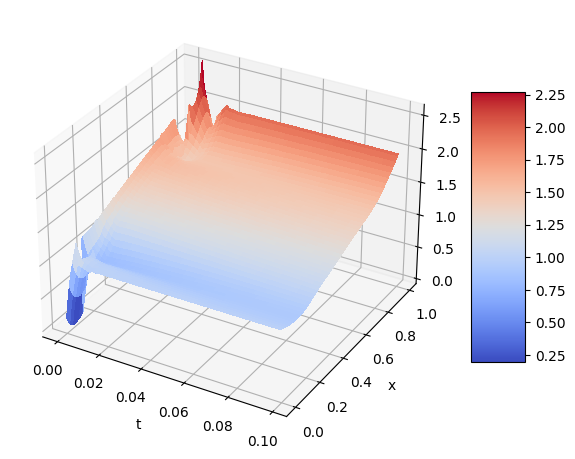

In [367]:
sol.plot2d()

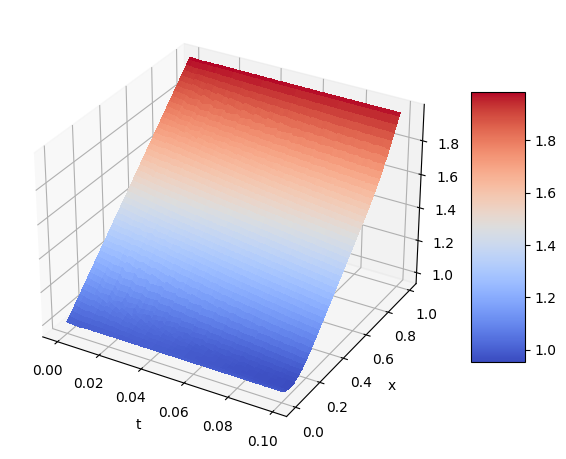

In [398]:
sol.plot2d()

In [397]:
sol.solve(**iteration_dict, verbose=True)

0.0020285158778095003
0.0018933940149787887
0.0017551996030098493
0.0015732227622824446
0.0014401176354432443
0.001359839043163072
0.0012930282525507944
0.0012341283835076988
0.0011788605219986356
0.0011269377559256222
0.0010781078167055314
0.0010380838291466077
0.0010065996998089854
0.0009764000830796427
0.0009474695246061149
0.0009197564584861873
0.0008931963856086966
0.0008677228972169271
0.000843272479617907
0.0008197862565140213
0.0007972103015290166
0.0007754953419691901
0.0007545962512407467
0.0007344715128576595
0.0007150827312714103
0.0006963942142179658
0.0006783726275563229
0.0006609867150080273
0.0006442070716390358
0.0006280059606100785
0.0006123571641427628
0.0005972358607360118
0.000582618522515066
0.0005690404433338347
0.0005559113919915148
0.0005431664948267745
0.0005307909339558048
0.0005187706142693038
0.0005070921121201888
0.000495742630794993
0.00048470996167138125
0.00047398244977459036
0.0004635489628384004
0.0004533988633377284


KeyboardInterrupt: 

In [390]:
prepared_coefs = sol.cells_coefs

In [379]:
sol.dim_sizes

array([16,  8])

In [396]:
sol.cells_coefs = prepared_coefs